## Download image data

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise window.open() coomand doesn't work. Then you can run the following commands:

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [3]:
from fastai.vision import *
import torchvision as tv

In [4]:
base_dir ='data/'
folder = 'soup'
file = 'soup.url'
path = Path(base_dir +'liquid')

In [5]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
# download_images(path/file, dest, max_pics=400)

In [6]:
folder = 'drink'
file = 'drink.url'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
# download_images(path/file, dest, max_pics=400)

In [7]:
path.ls()

[WindowsPath('data/liquid/.ipynb_checkpoints'),
 WindowsPath('data/liquid/cleaned.csv'),
 WindowsPath('data/liquid/drink'),
 WindowsPath('data/liquid/drink.url'),
 WindowsPath('data/liquid/models'),
 WindowsPath('data/liquid/soup'),
 WindowsPath('data/liquid/soup.url')]

In [8]:
classes = ['drink','soup']

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=800)

drink


soup


## View data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".",bs=32, valid_pct=0.3,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
        

In [9]:
data.classes

['drink', 'soup']

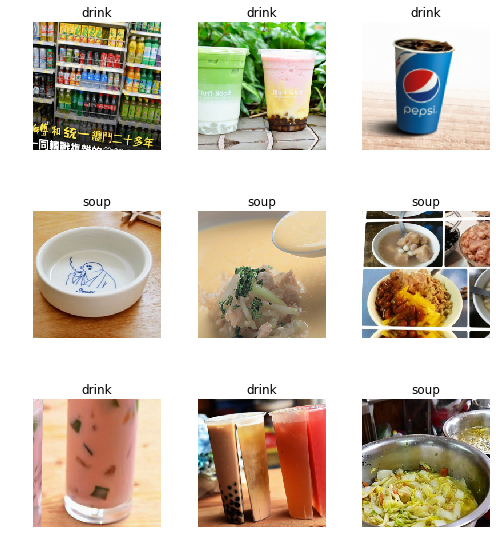

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['drink', 'soup'], 2, 469, 201)

## Train model

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.482383,0.203109,0.084577,02:21
1,0.303246,0.137702,0.054726,02:17
2,0.199576,0.131438,0.039801,02:31
3,0.154732,0.136157,0.044776,03:12


In [14]:
import  torch
if(torch.cuda.is_available()):
    torch.cuda.get_device_name(0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


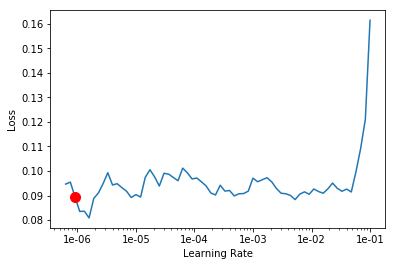

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.save('stage-1')

In [17]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.052866,0.130142,0.039801,02:45
1,0.082940,0.135125,0.039801,02:36
2,0.082733,0.132486,0.039801,02:53
3,0.079648,0.131880,0.044776,02:40


In [18]:
learn.save('stage-2')

## Interpretation

In [19]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

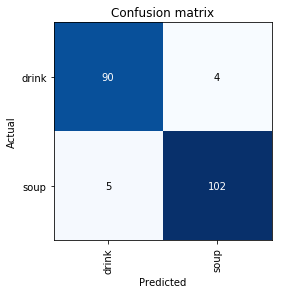

In [21]:
interp.plot_confusion_matrix()

In [22]:
from fastai.widgets import *

In [23]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )


In [24]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [25]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln
                                             , ds_type=DatasetType.Valid
                                             , n_img=20)

In [26]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [27]:
ds, idxs = DatasetFormatter().from_similars(learn_cln, 
                                            ds_type=DatasetType.Valid, 
                                            n_imgs=10)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Remove similar images and fix some labels

In [10]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".",bs=32, csv_labels="cleaned.csv",valid_pct=0.3,
        ds_tfms=get_transforms(), size=224, num_workers=2).normalize(imagenet_stats)
        
data.classes

['drink', 'soup']

In [11]:
len(data.valid_ds),len(data.train_ds)

(201, 469)

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.533440,0.225097,0.094527,02:17
1,0.363884,0.164510,0.039801,02:12
2,0.272355,0.144183,0.039801,02:10
3,0.212599,0.144256,0.044776,02:08


In [33]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.save('stage-3')

# New Section

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


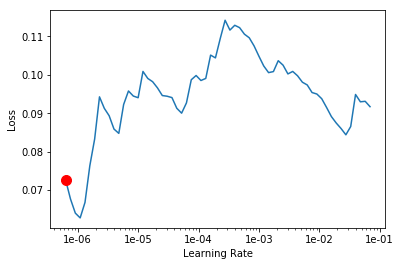

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
torch.cuda.empty_cache() 

In [13]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (469 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
drink,drink,drink,drink,drink
Path: data\liquid;

Valid: LabelList (201 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
soup,drink,soup,soup,drink
Path: data\liquid;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [14]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,1e-4))
# learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.057293,0.135503,0.039801,02:16
1,0.050592,0.141878,0.039801,02:14
2,0.043776,0.119221,0.034826,02:15
3,0.040653,0.114088,0.029851,02:16


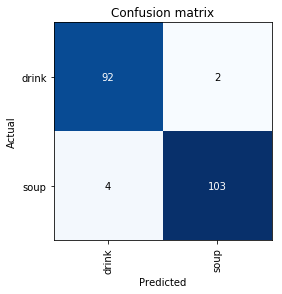

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


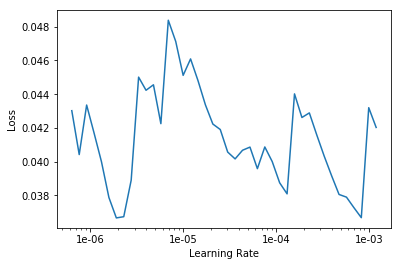

In [20]:
learn.recorder.plot()

In [21]:
learn.save('model3')

In [22]:
learn.load('model3')

Learner(data=ImageDataBunch;

Train: LabelList (469 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
drink,drink,drink,drink,drink
Path: data\liquid;

Valid: LabelList (201 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
soup,drink,soup,soup,drink
Path: data\liquid;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [23]:
mpath = os.getcwd()+ "/models"
final_model_name='model.pkl'
shutil.rmtree(mpath ,ignore_errors=True)
if not os.path.exists(mpath):
        os.mkdir(mpath)      

In [24]:
learn.export(mpath+f"/{final_model_name}")

### Export whole classifier

In [25]:
#learn.export() #export much thing include model,learn obj (metadata like the classes or the transforms/normalization used)

In [26]:
learn = load_learner(path=mpath, file=final_model_name)

Category drink

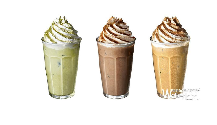

In [27]:
img = open_image(path/'drink'/'00000079.jpg')
img.show()
pred_class,pred_idx,outputs = learn.predict(img)
pred_class